In [1]:
%pip install -U LeXmo

Note: you may need to restart the kernel to use updated packages.


In [3]:
import nltk
nltk.download('punkt')
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import requests
from LeXmo import LeXmo
from tqdm import tqdm

import pickle


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# "Dataline","Play","PlayerLinenumber","ActSceneLine","Player","PlayerLine"

# read caesar.CSV
df = pd.read_csv('caesar.csv', encoding='utf-8')
dict = df.to_dict('records')
# create a list of major characters

characters = ['BRUTUS', 'CAESAR', 'ANTONY', 'CASSIUS', 'OCTAVIUS', 'PORTIA']

# read CSV and create a list of lines and ActSceneLine for each character
characterLines = {}

total = 0

for character in characters:
    characterLines[character] = {}
    playerLineNumber = -1


    # refers to the ActSceneLine of the start of each piece of dialogue
    currentLocation = ''

    for row in tqdm(dict):
        # if next bit of text is from the same character, append
        if row['Player'] == character:
            if row['PlayerLinenumber'] == playerLineNumber:
                characterLines[character][currentLocation]['text'] += ' ' + row['PlayerLine']
                # not the same bit, so new line
            else:
                currentLocation = row['ActSceneLine']
                characterLines[character][currentLocation] = {}
                characterLines[character][currentLocation]['text'] = row['PlayerLine']
                playerLineNumber = row['PlayerLinenumber']

    total += len(characterLines[character])

print(total)



100%|██████████| 2771/2771 [00:00<00:00, 923440.04it/s]

459


In [4]:
# save sentiment analysis of each line

for character in characters:
    for location in tqdm(characterLines[character]):
        sentiment = LeXmo.LeXmo(characterLines[character][location]['text'])
        sentiment.pop('text', None)
        characterLines[character][location]['sentiment'] = sentiment
    
print(characterLines['BRUTUS'])

100%|██████████| 16/16 [00:13<00:00,  1.16it/s]

{'1.2.23': {'text': 'A soothsayer bids you beware the ides of March.', 'sentiment': {'anger': 0.0, 'anticipation': 0.0, 'disgust': 0.0, 'fear': 0.0, 'joy': 0.0, 'negative': 0.0, 'positive': 0.1, 'sadness': 0.0, 'surprise': 0.0, 'trust': 0.0}}, '1.2.30': {'text': 'Not I.', 'sentiment': {'anger': 0.0, 'anticipation': 0.0, 'disgust': 0.0, 'fear': 0.0, 'joy': 0.0, 'negative': 0.0, 'positive': 0.0, 'sadness': 0.0, 'surprise': 0.0, 'trust': 0.0}}, '1.2.32': {'text': "I am not gamesome: I do lack some part Of that quick spirit that is in Antony. Let me not hinder, Cassius, your desires, I'll leave you.", 'sentiment': {'anger': 0.0, 'anticipation': 0.0, 'disgust': 0.0, 'fear': 0.0, 'joy': 0.0, 'negative': 0.029411764705882353, 'positive': 0.029411764705882353, 'sadness': 0.0, 'surprise': 0.0, 'trust': 0.0}}, '1.2.41': {'text': "Cassius, Be not deceived: if I have veil'd my look, I turn the trouble of my countenance Merely upon myself. Vexed I am Of late with passions of some difference, Concep

In [5]:
# save characterLines to pickle file

with open('characterLines.pickle', 'wb') as handle:
    pickle.dump(characterLines, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [6]:
# load characterLines from pickle file
characterLines = None
with open('characterLines.pickle', 'rb') as handle:
    characterLines = pickle.load(handle)

print(characterLines['PORTIA'])

{'2.1.244': {'text': 'Brutus, my lord!', 'sentiment': {'anger': 0.0, 'anticipation': 0.0, 'disgust': 0.2, 'fear': 0.0, 'joy': 0.0, 'negative': 0.2, 'positive': 0.2, 'sadness': 0.0, 'surprise': 0.0, 'trust': 0.2}}, '2.1.248': {'text': "Nor for yours neither. You've ungently, Brutus, Stole from my bed: and yesternight, at supper, You suddenly arose, and walk'd about, Musing and sighing, with your arms across, And when I ask'd you what the matter was, You stared upon me with ungentle looks, I urged you further, then you scratch'd your head, And too impatiently stamp'd with your foot, Yet I insisted, yet you answer'd not, But, with an angry wafture of your hand, Gave sign for me to leave you: so I did, Fearing to strengthen that impatience Which seem'd too much enkindled, and withal Hoping it was but an effect of humour, Which sometime hath his hour with every man. It will not let you eat, nor talk, nor sleep, And could it work so much upon your shape As it hath much prevail'd on your cond

[575, 1127, 1760, 2218]


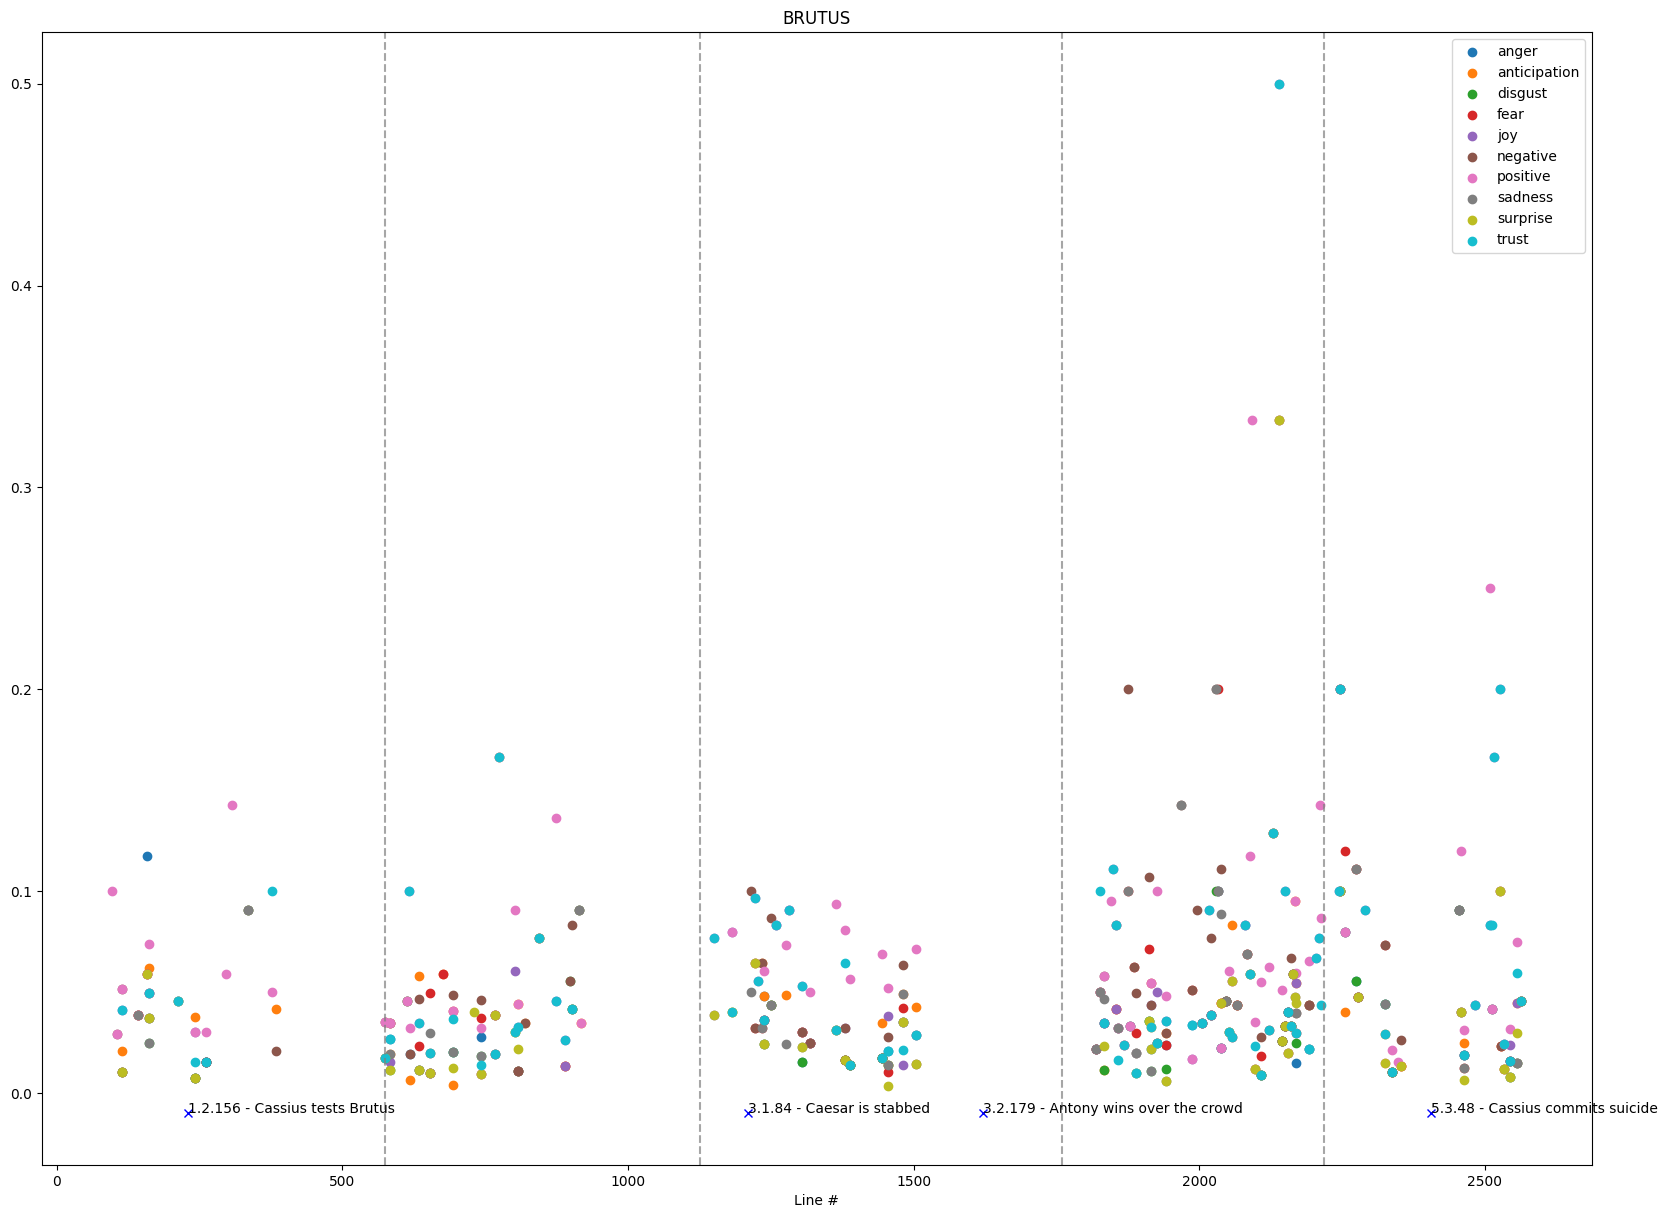

In [117]:
figure(figsize=(20, 15), dpi=100)

lastXpoint = 0

# plot Brutus' sentiment over time
allSentiments = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
uniqueLocations = df['ActSceneLine'].unique().tolist()
# convert location to x coordinate
def locationToX(location):
    numLocations = len(uniqueLocations)
    for i in range(numLocations):
        if location == uniqueLocations[i]:
            return i


# plot sentiment over time

# act dividers
dividers = []
for divider in ['2.1.1', '3.1.1', '4.1.1', '5.1.1']:
    dividers.append(locationToX(divider))
print(dividers)

def plotSentiment(character, sentiment, plot=True):
    x = []
    y = []
    for location in characterLines[character]:
        # only plot sentiments > 0      
        if characterLines[character][location]['sentiment'][sentiment] > 0:
            x.append(locationToX(location))
            y.append(characterLines[character][location]['sentiment'][sentiment])
    
    if plot:

        # plot scatter plot
        plt.scatter(x, y, label=sentiment)

        plt.title(character)

        plt.legend()
        plt.xlabel('Line #')
        # plt.ylim(0, 1)
    return x[len(x)-1]

def plotAllSentiment(character):
    lastPoints = []
    for sentiment in allSentiments:
        lastPoints.append(plotSentiment(character, sentiment))
    plotLabels(max(lastPoints))


def plotLabels(x):

    labels = [
        ('1.2.156 - Cassius tests Brutus', locationToX('1.2.156')),
        ('3.1.84 - Caesar is stabbed', locationToX('3.1.84')),
        ('3.2.179 - Antony wins over the crowd', locationToX('3.2.179')),
        ('5.3.48 - Cassius commits suicide', locationToX('5.3.48'))
    ]  

    for label in labels:
        if label[1] < x:
            plt.text(label[1], -0.01, label[0], horizontalalignment='left')

            plt.plot(label[1], -0.01, color='blue', marker='x')

     # plot vertical lines at dividers
    for divider in dividers:
        plt.axvline(divider, color='grey', linestyle='--', alpha=0.7)


# characters = ['BRUTUS', 'CAESAR', 'ANTONY', 'CASSIUS', 'OCTAVIUS', 'PORTIA']
plotAllSentiment('BRUTUS')

{'anger': 0.008335833456111856, 'anticipation': 0.016825708728861483, 'disgust': 0.007882844734089718, 'fear': 0.013389832421628998, 'joy': 0.015600375596876182, 'negative': 0.02252593006461289, 'positive': 0.03974440164952199, 'sadness': 0.013658684615241282, 'surprise': 0.011446576693920444, 'trust': 0.024913481613259097}


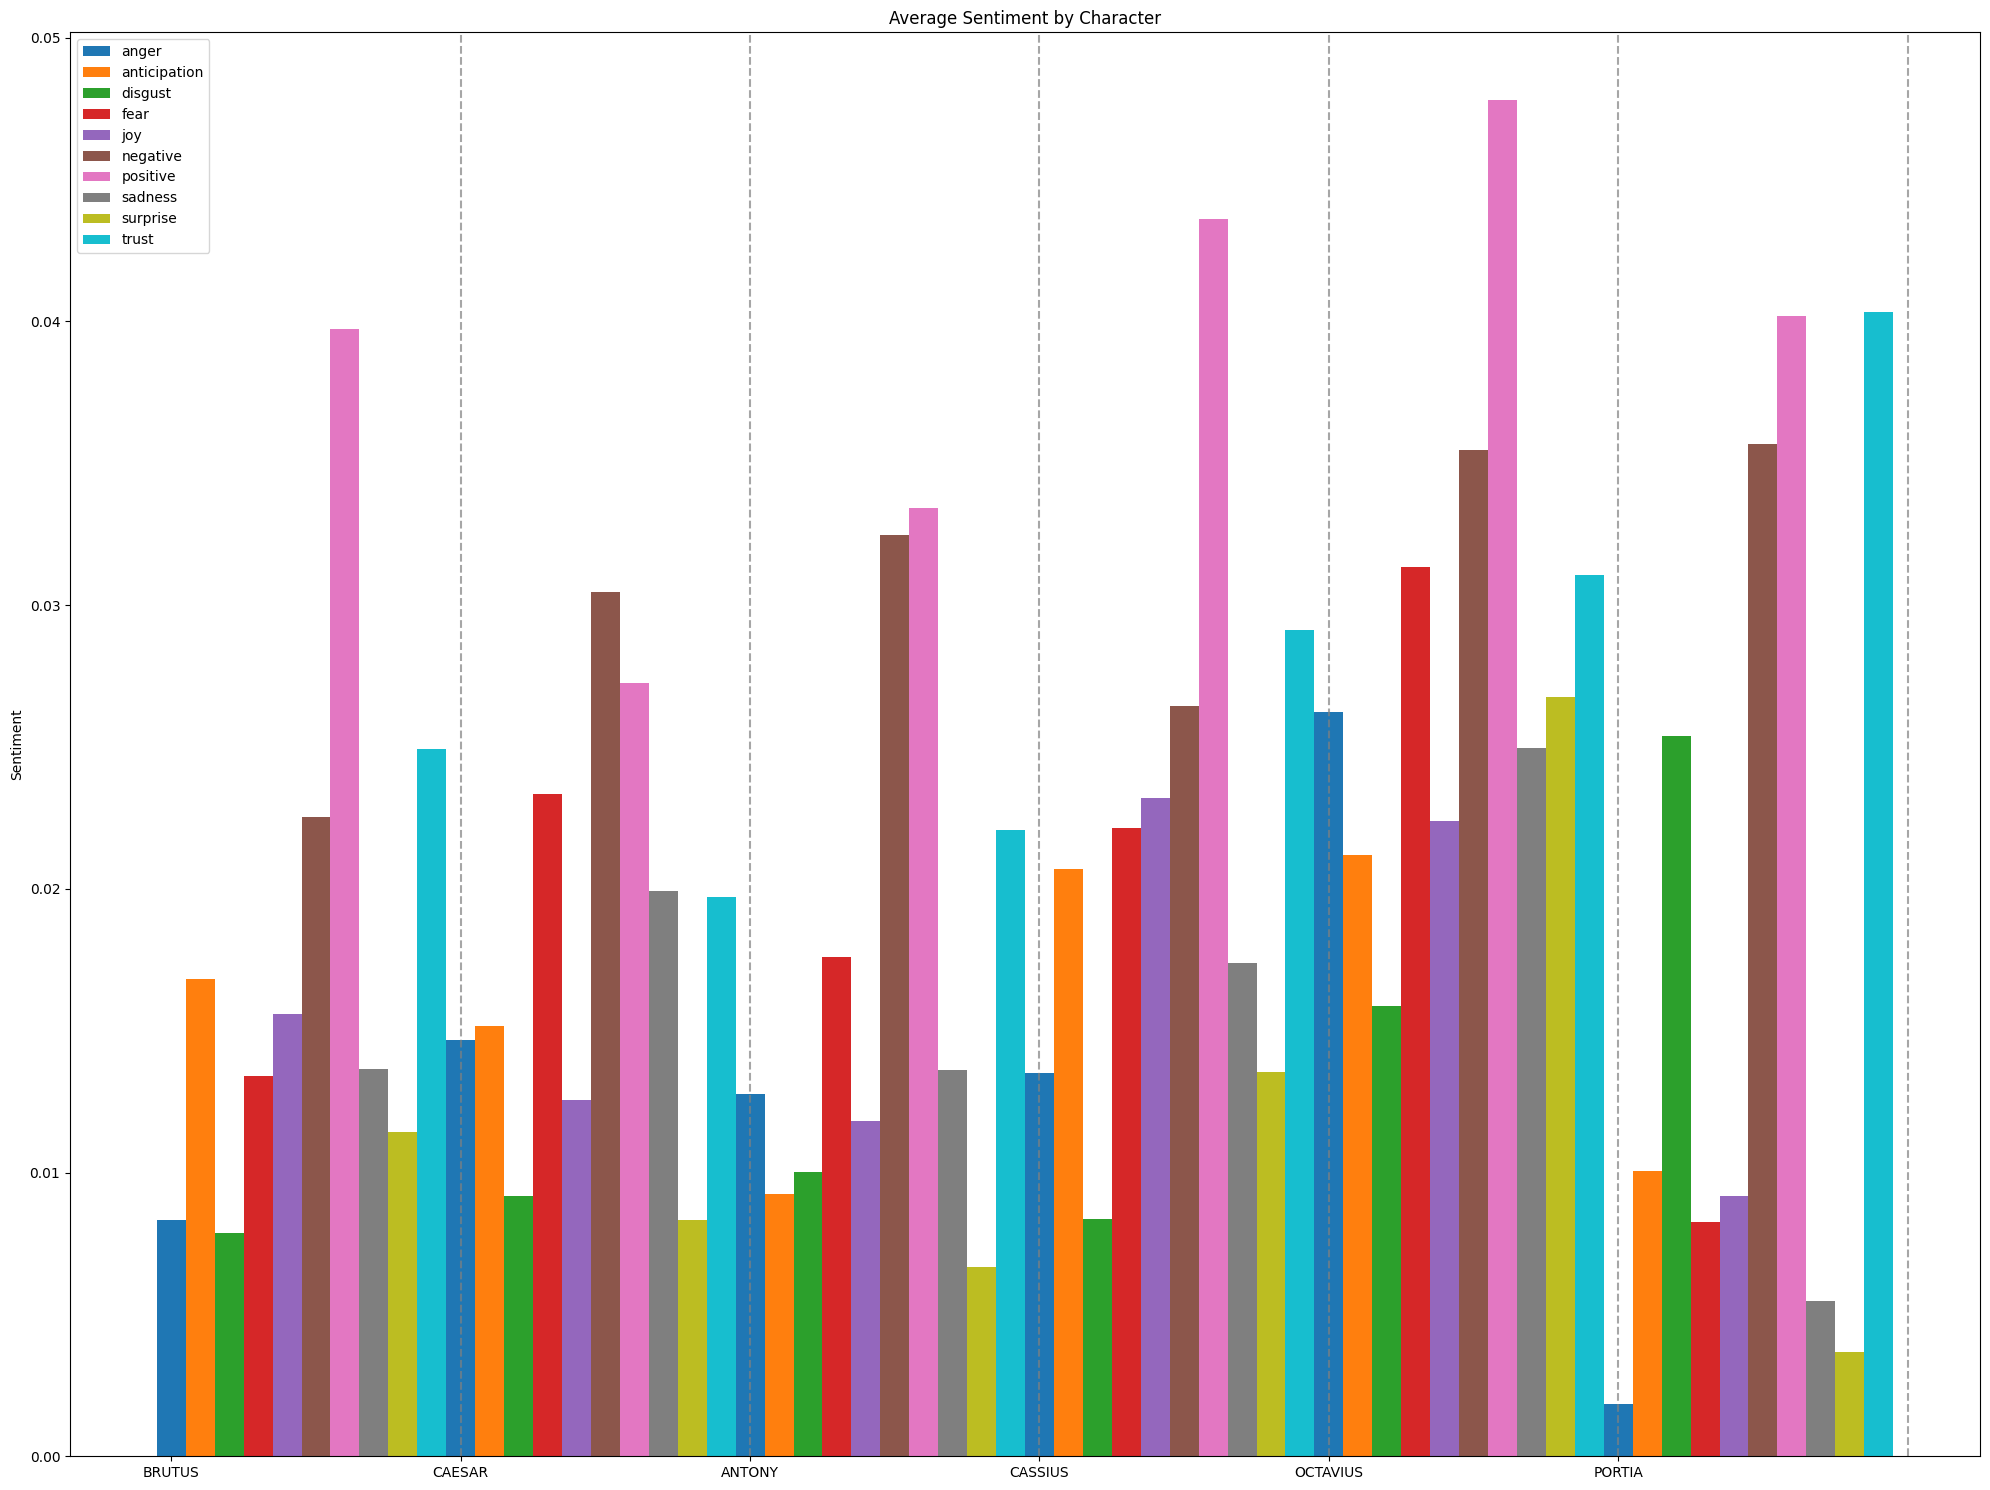

In [105]:
# graphing average sentiment

def getAverageSentiment(character):
    averageSentiments = {}
    for sentiment in allSentiments:
        averageSentiments[sentiment] = 0
    for location in characterLines[character]:
        for sentiment in allSentiments:
            averageSentiments[sentiment] += characterLines[character][location]['sentiment'][sentiment] 
    for sentiment in averageSentiments:
        averageSentiments[sentiment] /= len(characterLines[character])
    return averageSentiments

print(getAverageSentiment('BRUTUS'))

averageSentiments = {}

for char in characters:
    averageSentiments[char] = getAverageSentiment(char)

# plot average sentiments

x = np.arange(len(characters))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 15), dpi=100)
rects = []
for i in range(len(allSentiments)):
    rects.append(ax.bar(x + width * i, [averageSentiments[char][allSentiments[i]] for char in characters], width, label=allSentiments[i]))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sentiment')
ax.set_title('Average Sentiment by Character')
ax.set_xticks(x)
ax.set_xticklabels(characters)
ax.legend()
        

fig.tight_layout()

# add space between each character
for i in range(len(characters)):
    ax.axvline(x[i] + width * len(allSentiments), color='grey', linestyle='--', alpha=0.7)



plt.show()


In [8]:
# look through Brutus sentiment and find line with highest sentiment value

def maxSentiment(character, sentiment):
    max = 0
    maxLocation = ['','', 0]
    for location in characterLines[character]:
        if characterLines[character][location]['sentiment'][sentiment] > max:
            max = characterLines[character][location]['sentiment'][sentiment]
            maxLocation[0] = location
            maxLocation[1] = characterLines[character][location]['text']
            maxLocation[2] = max
    return [sentiment] + maxLocation

for sentiment in allSentiments:
    print(maxSentiment('BRUTUS', sentiment))

['anger', '1.2.84', 'What means this shouting? I do fear, the people Choose Caesar for their king.', 0.11764705882352941]
['anticipation', '4.3.270', 'Good night, good brother.', 0.3333333333333333]
['disgust', '4.3.160', 'O Cassius, I am sick of many griefs.', 0.1]
['fear', '4.3.163', 'No man bears sorrow better. Portia is dead.', 0.2]
['joy', '4.3.270', 'Good night, good brother.', 0.3333333333333333]
['negative', '4.3.6', 'You wronged yourself to write in such a case.', 0.2]
['positive', '4.3.270', 'Good night, good brother.', 0.5]
['sadness', '4.3.160', 'O Cassius, I am sick of many griefs.', 0.2]
['surprise', '4.3.270', 'Good night, good brother.', 0.3333333333333333]
['trust', '4.3.270', 'Good night, good brother.', 0.5]


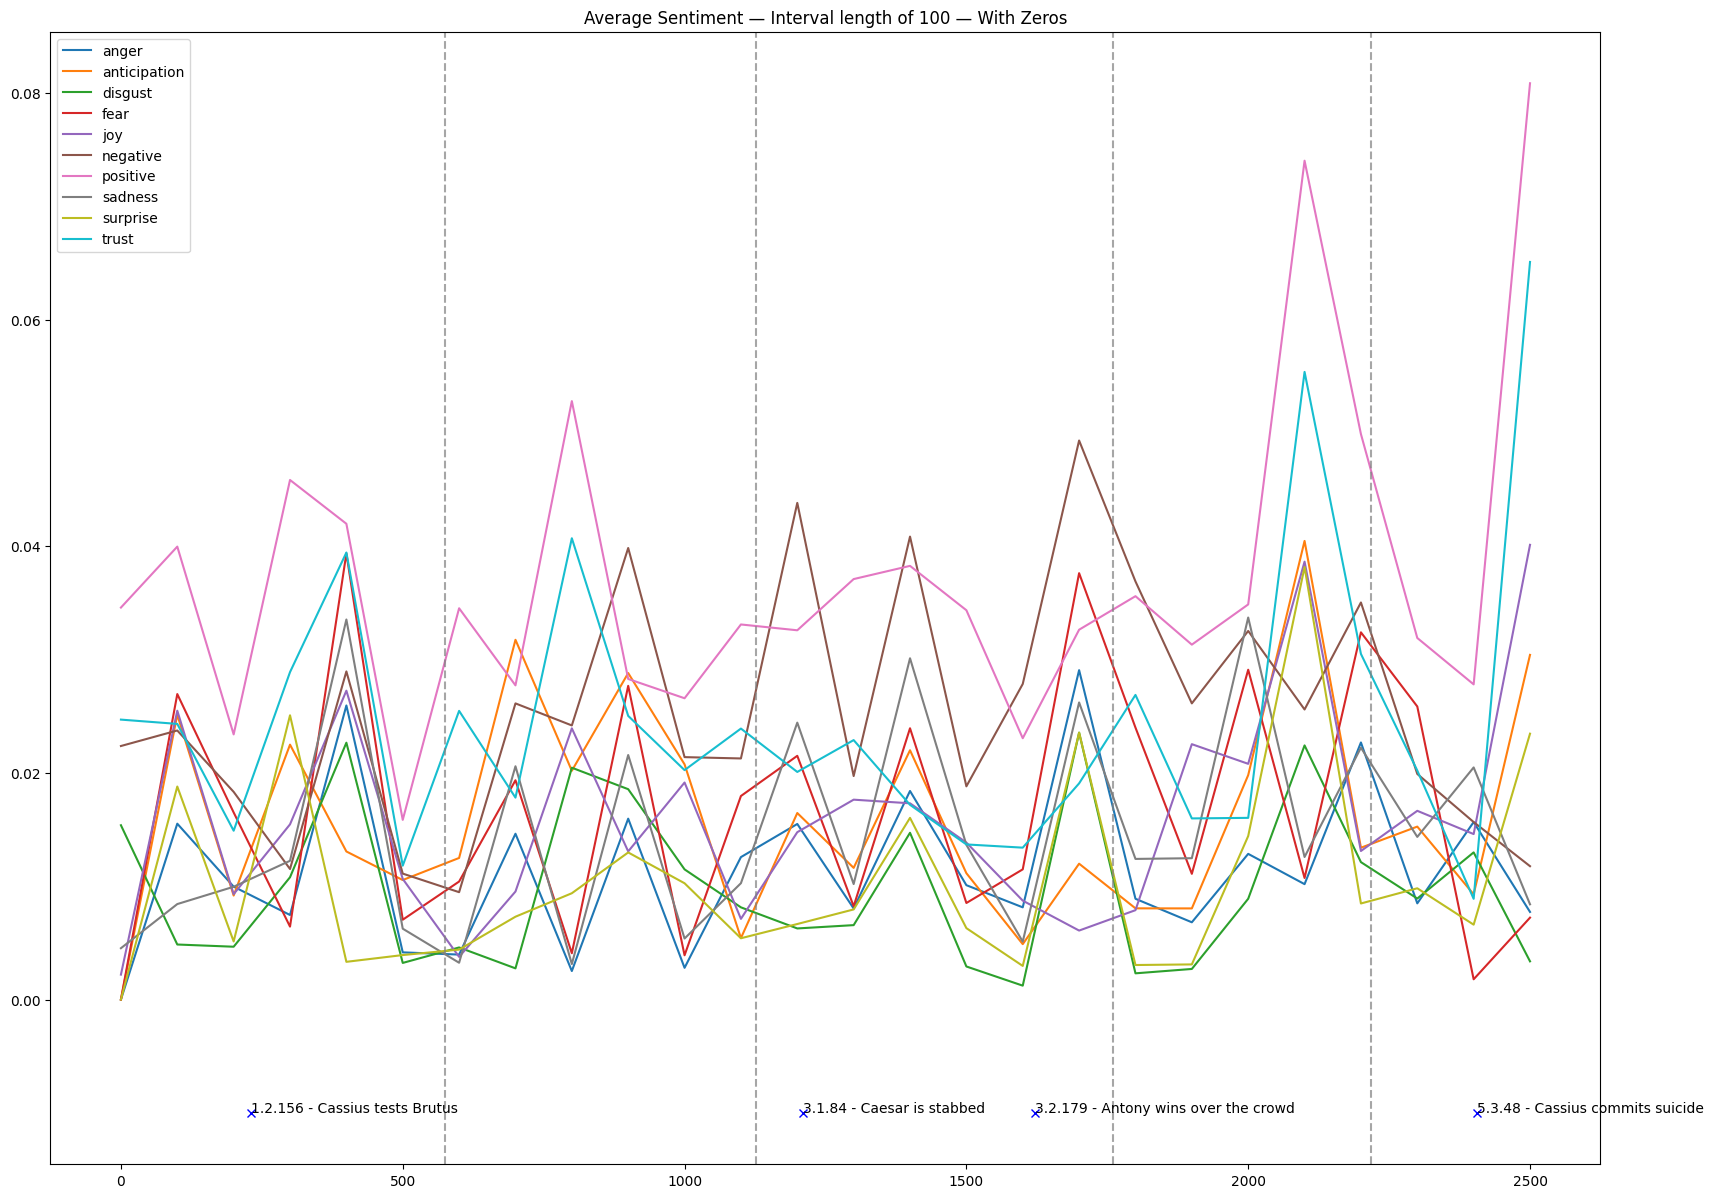

In [116]:
figure(figsize=(20, 15), dpi=100)

label = ''
def getAverageSentimentOverall(characters, includeZeros=True, intervalSize=100, removeOutliers=False):
    outliers = ['4.3.270', # Brutus, good night, good brother

    ]
    # get average sentiment across all characters in internvals of 50 lines
    averageSentimentOverall = []
    for i in range(0, len(uniqueLocations), intervalSize):
        averageSentimentInterval = {}
        for sentiment in allSentiments:
            averageSentimentInterval[sentiment] = []
        for character in characters:
            
            for location in characterLines[character]:
                if not (removeOutliers and location in outliers):
                    if locationToX(location) >= i and locationToX(location) < i + intervalSize:
                        for sentiment in allSentiments:
                            sent = characterLines[character][location]['sentiment'][sentiment]
                            if sent > 0 or includeZeros:
                                averageSentimentInterval[sentiment].append(sent)

        for sentiment in averageSentimentInterval:
            divideBy = len(averageSentimentInterval[sentiment])
            if divideBy == 0:
                 divideBy = 1 # prevent divide by zero
            averageSentimentInterval[sentiment] = sum(averageSentimentInterval[sentiment]) / divideBy

        averageSentimentOverall.append(averageSentimentInterval)

        global label
        label = 'With Zeros' if includeZeros else 'Without Zeros'
    return averageSentimentOverall

aveSentimentOverall = getAverageSentimentOverall(characters, True, 100, True)
# print(len(aveSentimentOverall))
# print(len(uniqueLocations)/intervalSize)

# line graph of average sentiment at each location

def plotAverageSentimentOverall(data, intervalSize=100):
    x = []
    for i in range(0, len(uniqueLocations), intervalSize):
        x.append(i)
    for sentiment in allSentiments:
        y = []
        for i in range(len(data)):
            y.append(data[i][sentiment])

        plt.plot(x, y, label=sentiment)
    plt.legend()
    plt.title('Average Sentiment — Interval length of ' + str(intervalSize) + ' — ' + label)
    plotLabels(len(uniqueLocations))

plotAverageSentimentOverall(aveSentimentOverall, 100)

# plot average sentiment overall in step graph
def plotAverageSentimentOverallStep(data, intervalSize=100):
    x = []
    for i in range(0, len(uniqueLocations), intervalSize):
        x.append(i)
    for sentiment in allSentiments:
        y = []
        for i in range(len(data)):
            y.append(data[i][sentiment])

        plt.step(x, y, label=sentiment)
    plt.legend()
    plt.title('Average Sentiment — Interval length of ' + str(intervalSize) + ' — ' + label)
    plotLabels(len(uniqueLocations))

# plotAverageSentimentOverallStep(aveSentimentOverall)

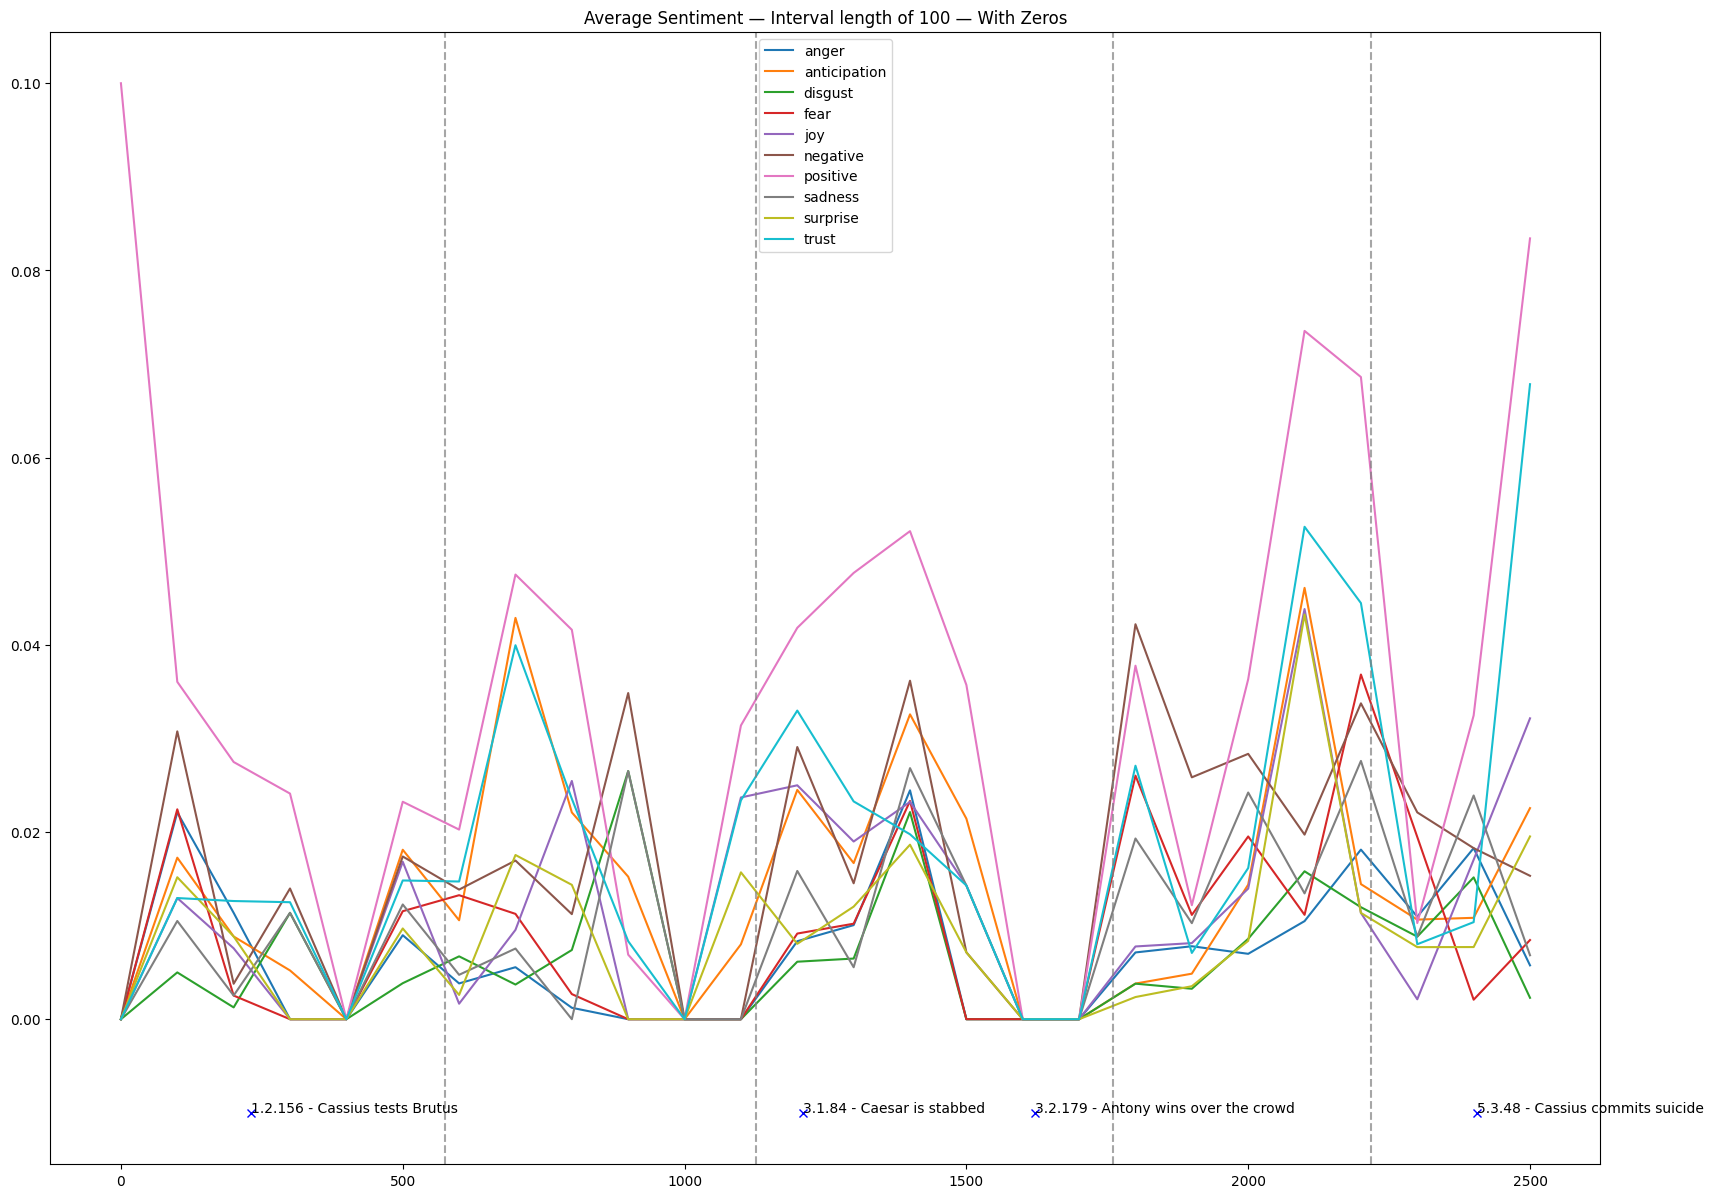

In [102]:
# Plot average sentiment for individual characters across intervals
figure(figsize=(20, 15), dpi=100)
aveSentimentChar = getAverageSentimentOverall(['BRUTUS'], True)

plotAverageSentimentOverall(aveSentimentChar)

### Word cloud with the most frequently used words from each character ### 


In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\JingHong
[nltk_data]     Huang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

def get_word_freq_dict(char_name):
    '''
    Returns a dictionary of word frequencies for a given character
    '''
    # Get a list of English stop words
    stop_words = stopwords.words('english')
    # add I, shall, thou, that, the, good, but, for, to be, and, of, in, to, let to the stop_words, with first letter capitalized and not capitalized
    stop_words.extend(['I', 'shall', 'thou', 'that', 'the', 'good', 'but', 'for', 'to', 'be', 'and', 'of', 'in', 'to', 'let', 'thee', 'thy'])
    # add the stop words with first letter capitalized
    stop_words.extend([word.capitalize() for word in stop_words])
    # extend the character list to the stop words
    stop_words.extend(characters)
    # add all the names of the characters
    char = ['Brutus', 'Caesar', 'Antony', 'Cassius', 'Octavius', 'Portia', 'Cicero', 'Lucius', 'Mark', 'Lucilius', 'TITINIUS', 'Titinius', 'Casca', 'CASCA', 
    'Calpurnia', 'Antonius',  'LEPIDUS', 'Lepidus','DECIUS', 'Decius']
    stop_words.extend(char)


    
    # Create an empty counter object
    word_counter = Counter()
    
    for location in characterLines[char_name]:
        text = characterLines[char_name][location]['text']
        
        # Tokenize the text and only include "words" (i.e. not punctuation) in the counter
        word_counter.update([token for token in word_tokenize(text) if token.isalpha() and token not in stop_words])
    
    # Use a dict comprehension to create a dictionary with the words as keys and their frequencies as values
    word_freq_dict = {word: freq for word, freq in word_counter.most_common(50)}

    return word_freq_dict

In [5]:
nltk.download('stopwords')
Brutus_word_freq_dict = get_word_freq_dict('BRUTUS')
Caesar_word_freq_dict = get_word_freq_dict('CAESAR')
Antony_word_freq_dict = get_word_freq_dict('ANTONY')
Cassius_word_freq_dict = get_word_freq_dict('CASSIUS')
Octavius_word_freq_dict = get_word_freq_dict('OCTAVIUS')
Portia_word_freq_dict = get_word_freq_dict('PORTIA')

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\andre/nltk_data'
    - 'c:\\Users\\andre\\Anaconda3\\nltk_data'
    - 'c:\\Users\\andre\\Anaconda3\\share\\nltk_data'
    - 'c:\\Users\\andre\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\andre\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [17]:
%pip install wordcloud
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [19]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import random 

def plotWordCloud(image):
  # Input: word cloud image
  # Output: (display the small cloud image in the output)
    # Set figure size
    plt.figure(figsize=(5, 5))
    # Display image
    plt.imshow(image) 
    # No axis details
    plt.axis("off")

def generateWordCloud(text):
  # Input: all texts in the scraped wiki data.
  # Output: word cloud image.
  color_ls = ['blue', 'green', 'red', 'purple', 'orange', 'yellow']
  color = random.choice(color_ls)
  # make the color random and the background color blue

  # make the word cloud small 
  wordcloud = WordCloud(width= 2000, height = 2000, random_state=1, background_color= color, colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
  return wordcloud

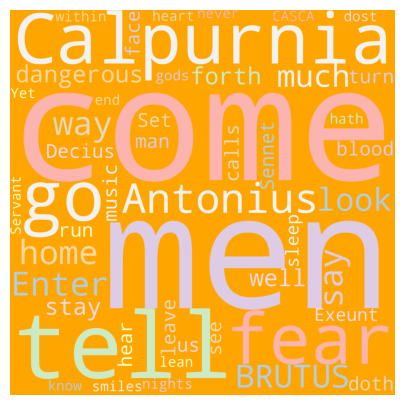

In [20]:
# create Caesar's word cloud
Caesar_word_cloud = generateWordCloud(' '.join(Caesar_word_freq_dict.keys()))
plotWordCloud(Caesar_word_cloud)

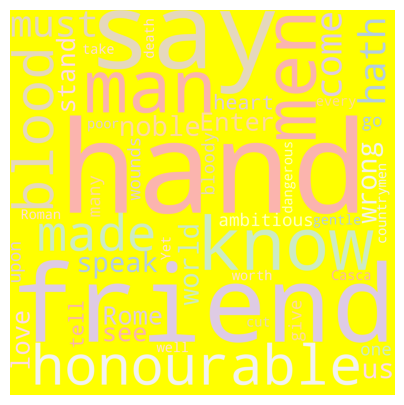

In [21]:
# create Antony's word cloud
Antony_word_cloud = generateWordCloud(' '.join(Antony_word_freq_dict.keys()))
plotWordCloud(Antony_word_cloud)

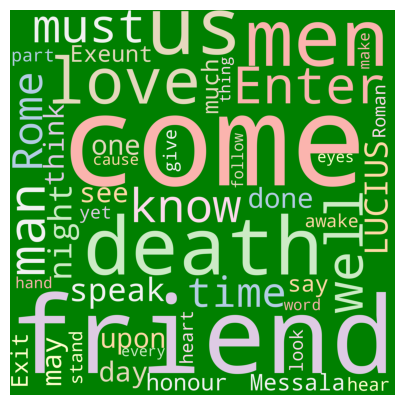

In [22]:
# create Brutus's word cloud 
Brutus_word_cloud = generateWordCloud(' '.join(Brutus_word_freq_dict.keys()))
plotWordCloud(Brutus_word_cloud)

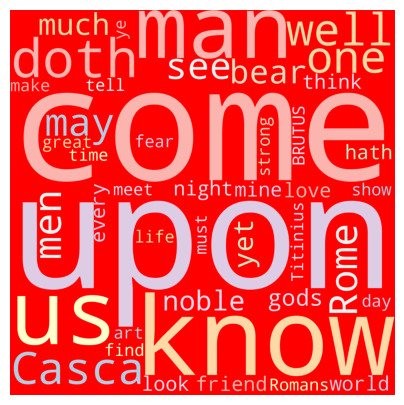

In [23]:
# create Cassius's word cloud
Cassius_word_cloud = generateWordCloud(' '.join(Cassius_word_freq_dict.keys()))
plotWordCloud(Cassius_word_cloud)

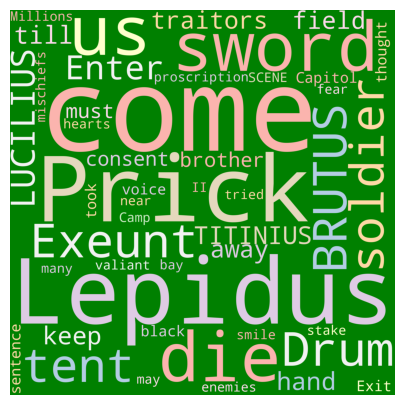

In [24]:
# create Octavius's word cloud
Octavius_word_cloud = generateWordCloud(' '.join(Octavius_word_freq_dict.keys()))
plotWordCloud(Octavius_word_cloud)

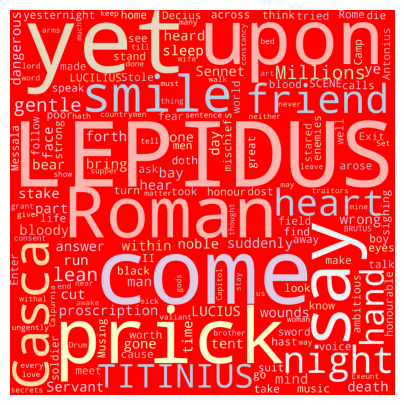

In [26]:
# create a word cloud for all characters
all_characters = Brutus_word_freq_dict.keys() | Caesar_word_freq_dict.keys() | Antony_word_freq_dict.keys() | Cassius_word_freq_dict.keys() | Octavius_word_freq_dict.keys() | Portia_word_freq_dict.keys()   
all_characters_word_cloud = generateWordCloud(' '.join(all_characters))
plotWordCloud(all_characters_word_cloud)